# Machine Learning / Classification + Confusion Matrix + F1 (Telco Churn)

Amaç:
- Confusion Matrix mantığı
- Precision / Recall / F1
- Threshold (0.3 / 0.5 / 0.7)
- Logistic Regression ile feature etkisi fikri

Dataset:
- `WA_Fn-UseC_-Telco-Customer-Churn.csv`


## Kurulum


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)
sns.set_theme()
print("Hazır!")


Hazır!


## 1) Veriyi yükle


In [ ]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) Hedef + Split


**Neden customerID çıkarılıyor?**
- Kimlik verisi -> genellenebilir desen değil
- OneHot ile binlerce sütun açıp modeli şişirir
- Yeni müşteri gelince ID farklı olacagı için işe yaramaz


In [ ]:
df = df.copy()
df["Churn_flag"] = (df["Churn"] == "Yes").astype(int)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

drop_cols = ["Churn", "Churn_flag", "customerID"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["Churn_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("customerID var mı?", "customerID" in X.columns)


Train: (5634, 19) Test: (1409, 19)
customerID var mı? False


## 3) Pipeline + Logistic Regression


In [ ]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

prep = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

pipe = Pipeline([
    ("prep", prep),
    ("model", LogisticRegression(max_iter=800))
])

pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("Precision:", round(precision_score(y_test, pred), 4))
print("Recall   :", round(recall_score(y_test, pred), 4))
print("F1       :", round(f1_score(y_test, pred), 4))
print("ROC-AUC  :", round(roc_auc_score(y_test, proba), 4))


Precision: 0.6572
Recall   : 0.5588
F1       : 0.604
ROC-AUC  : 0.8421


## 4) Confusion Matrix


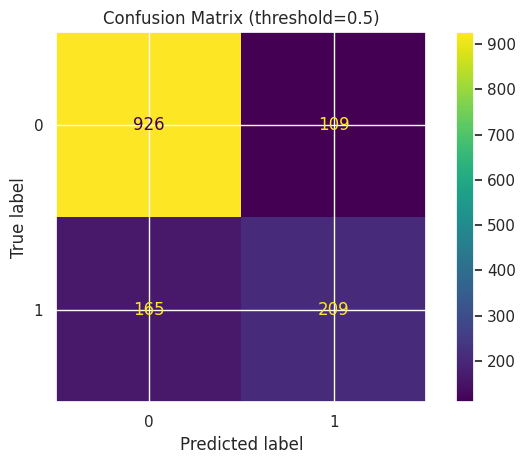

In [ ]:
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (threshold=0.5)")
plt.tight_layout()
plt.show()


## 5) Classification Report


In [ ]:
print(classification_report(y_test, pred, target_names=["No Churn","Churn"]))


              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



## 6) Threshold değişimi


In [ ]:
def metrics_at(th):
    p = (proba >= th).astype(int)
    return {
        "threshold": th,
        "precision": precision_score(y_test, p),
        "recall": recall_score(y_test, p),
        "f1": f1_score(y_test, p)
    }

pd.DataFrame([metrics_at(t) for t in [0.3, 0.5, 0.7]]).round(4)


,threshold,precision,recall,f1
0,0.3,0.5193,0.7540,0.6150
1,0.5,0.6572,0.5588,0.6040
2,0.7,0.7419,0.1845,0.2955


## 7) Feature etkisi: Logistic Regression katsayıları


Not:
- OneHotEncoding yüzünden çok fazla feature oluşur.
- Katsayı (+) churn olasılığını artırır, (-) azaltır (genel fikir).


In [ ]:
feature_names = pipe.named_steps["prep"].get_feature_names_out()
coef = pipe.named_steps["model"].coef_.ravel()

imp = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

print("En güçlü 10 etki (mutlak):")
imp.head(10)


En güçlü 10 etki (mutlak):


,feature,coef,abs_coef
1,num__tenure,-1.257539,1.257539
38,cat__Contract_Two year,-0.776594,0.776594
15,cat__InternetService_DSL,-0.648646,0.648646
16,cat__InternetService_Fiber optic,0.634195,0.634195
2,num__MonthlyCharges,-0.591863,0.591863
36,cat__Contract_Month-to-month,0.582883,0.582883
3,num__TotalCharges,0.536253,0.536253
39,cat__PaperlessBilling_No,-0.343227,0.343227
25,cat__DeviceProtection_No internet service,-0.300104,0.300104
17,cat__InternetService_No,-0.300104,0.300104


In [ ]:
print("Churn artıran (+) ilk 8:")
imp.sort_values("coef", ascending=False).head(8)


Churn artıran (+) ilk 8:


,feature,coef,abs_coef
16,cat__InternetService_Fiber optic,0.634195,0.634195
36,cat__Contract_Month-to-month,0.582883,0.582883
3,num__TotalCharges,0.536253,0.536253
35,cat__StreamingMovies_Yes,0.200938,0.200938
32,cat__StreamingTV_Yes,0.200481,0.200481
43,cat__PaymentMethod_Electronic check,0.197867,0.197867
18,cat__OnlineSecurity_No,0.156279,0.156279
27,cat__TechSupport_No,0.131503,0.131503


In [ ]:
print("Churn azaltan (-) ilk 8:")
imp.sort_values("coef", ascending=True).head(8)


Churn azaltan (-) ilk 8:


,feature,coef,abs_coef
1,num__tenure,-1.257539,1.257539
38,cat__Contract_Two year,-0.776594,0.776594
15,cat__InternetService_DSL,-0.648646,0.648646
2,num__MonthlyCharges,-0.591863,0.591863
39,cat__PaperlessBilling_No,-0.343227,0.343227
19,cat__OnlineSecurity_No internet service,-0.300104,0.300104
17,cat__InternetService_No,-0.300104,0.300104
25,cat__DeviceProtection_No internet service,-0.300104,0.300104


## 8) Tahmin tablosu (ilk 15 kayıt)


In [ ]:
out = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": pred,
    "proba_churn": np.round(proba, 3)
})
out.head(15)


,y_true,y_pred,proba_churn
0,0,0,0.046
1,0,1,0.684
2,0,0,0.059
3,0,0,0.402
4,0,0,0.021
5,0,1,0.603
6,0,0,0.448
7,0,0,0.130
8,0,0,0.003
9,1,0,0.395
